In [1]:
from __future__ import print_function
from __future__ import division
import pandas as pd
import gzip
import time
import os, sys, time
import collections
from collections import Counter
import itertools

# Numerical manipulation libraries.
import numpy as np

#Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import json
import random

In [2]:
#Read MF neighbors data

with open('neighbors5.json', 'r') as f_:
     data = json.load(f_)
        
#Convert to a pandas df with item and similar items
df = pd.DataFrame(data.items(), columns=['item', 'similar'])

In [3]:
#Read product metadata
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

dfMeta = getDF('meta_Toys_and_Games.json.gz')
dfMeta['subCateg'] = dfMeta['categories'].map(lambda x:x[0][1] if len(x[0]) > 1 else x[0][0])

In [4]:
#Read product features from reviews
# dfTextF = pd.read_csv('product_features.tar.gz',compression = 'gzip') #old data before spelling fixes
# dfTextF.rename(columns = {'product_features.0.csv':'asin'," 'note'":'feature'}, inplace = True)
dfTextF = pd.read_csv('product_features.tgz',compression = 'gzip')
dfTextF.rename(columns = {'product_features.1.csv':'asin'," 'son'":'feature'}, inplace = True)
dfTextF.head()

,asin,4.0,434,feature
0,0670010936,4.0,289.0,'bear'
1,0670010936,5.0,469.0,'daughter'
2,0670010936,5.0,468.0,'granddaughter'
3,0670010936,5.0,454.0,'child'
4,0976990768,3.0,298.0,'skirt'


In [5]:
#Read product features from title and description
product_attribute_features_filepath = './product_attribute_features.harvested.0.csv'
with open('product_attribute_features.harvested.0.csv', mode='r') as in_f:
   productTitleDescFeatures = pd.read_csv(in_f, names=['asin','overall','feature'])
   print('File {} contains {} total product features.'.format(product_attribute_features_filepath,
                                                              len(productTitleDescFeatures)))
   print(productTitleDescFeatures[:10])

File ./product_attribute_features.harvested.0.csv contains 13105 total product features.
         asin   overall      feature
0  0439893577  4.352941   chalkboard
1  0439893577  4.352941   activities
2  0439893577  4.352941     tabletop
3  0439893577  4.352941     everyone
4  0615444172  5.000000      drawing
5  0615444172  5.000000      animals
6  0735333483  4.400000         farm
7  0786955708  3.818182         land
8  0786959916  4.648649         lord
9  0786964502  4.666667    expansion


#### Finding similars based on extracted product text features

In [6]:
#Function to display images of products given a list of urls
def showImages(images):
    from PIL import Image
    import requests
    from io import BytesIO

    imageswidth = len(images)*4
    fig=plt.figure(figsize=(imageswidth, 8))

    for i in range(0,len(images)):
        response = requests.get(images[i])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, len(images), i+1)
        plt.imshow(img)
        
# images = dfMeta[dfMeta['asin'].isin(babyUserItems)]['imUrl'].to_list()
# showImages(images)

In [7]:
prodList = dfTextF.groupby('asin').agg('count').index.to_list()
print(len(prodList))
prodList[:5]

11822


['0439893577', '048645195X', '0545496470', '0615444172', '0670010936']

In [31]:
def findSimilarsText(userItems): 
    
    userCategories = np.unique(dfMeta[dfMeta['asin'].isin(userItems)]['subCateg'].reset_index(drop = True))
#     print(userCategories)
    
    similarItems = []
    
    #Find all items with at least one feature in common with the user selected item features
    for item in userItems:
        reviewFeatures = dfTextF[dfTextF['asin'] == item]['feature'].to_list()
#         print(reviewFeatures)
        for feature in reviewFeatures:
            simProds = dfTextF[dfTextF['feature'] == feature]['asin'].to_list()
#             print(feature,len(simProds))
            for prod in simProds:
                if prod != item:
                    similarItems.append(prod)

        titleDescFeatures = productTitleDescFeatures[productTitleDescFeatures['asin'] == item]['feature'].to_list()
        for feature in titleDescFeatures:
            simProds = productTitleDescFeatures[productTitleDescFeatures['feature'] == feature]['asin'].to_list()
#             print(feature,len(simProds))
            for prod in simProds:
                if prod != item:
                    similarItems.append(prod)
                
    temp = dfMeta[dfMeta['asin'].isin(similarItems)]
#     print('subCategories',Counter(temp['subCateg']))
    selectSimilarItems = temp[temp['subCateg'].isin(userCategories)]['asin'].reset_index(drop = True)
    a = Counter(selectSimilarItems) #Items limited to same subcategory as user picked items
    b = Counter(similarItems) #All similar items irrespective of category
#     print('Number of items before and after limiting categories',len(b),len(a))
    
    recommendedItems = []
    for asin,count in a.most_common(6):
        recommendedItems.append(asin)
    for asin,count in b.most_common(6):
        recommendedItems.append(asin)
    
    return recommendedItems

In [113]:
#Function to read the similar items to all items in userItems (list of asins picked by user, and output the most common asins within those)
def findSimilarsMF(userItems):
    userCategories = np.unique(dfMeta[dfMeta['asin'].isin(userItems)]['subCateg'].reset_index(drop = True))
    similarItems = []
    
    similarItemsDf = df[df['item'].isin(userItems)]['similar'].reset_index(drop = True)
#     similarItems = [item for sublist in similarItemsDf for item in sublist]
    for i in range(similarItemsDf.shape[0]):
        for item in similarItemsDf[i]:
            similarItems.append(item)
#     print(len(similarItems),similarItems)
    
    for uItem in userItems:
        similarItems = [x for x in similarItems if x != uItem]
        
    temp = dfMeta[dfMeta['asin'].isin(similarItems)]
#     print('subCategories',Counter(temp['subCateg']))
    selectSimilarItems = temp[temp['subCateg'].isin(userCategories)]['asin'].reset_index(drop = True)
    
    a = Counter(selectSimilarItems) #Items limited to same subcategory as user picked items
    b = Counter(similarItems) #All similar items irrespective of category
    
    recommendedItems = []
    for asin,count in a.most_common(6):
        recommendedItems.append(asin)
    for asin,count in b.most_common(6):
        recommendedItems.append(asin)
    
    return recommendedItems

In [38]:
numSelections = 1
userItems = random.sample(prodList, numSelections)

Title and description based features
            asin  overall feature
2258  B000FEBVEK      4.8    tote
2259  B000FEBVEK      4.8    work
Review based features
            asin   4.0    434    feature
9581  B000FEBVEK   5.0  824.0   'course'
9582  B000FEBVEK   5.0  826.0      'joy'


,asin,description,title,price,salesRank,imUrl,brand,categories,related,subCateg
40685,B000FEBVEK,"Phone calls to make, e-mail to check, reports ...",Fisher Price Work-At-Home Office,53.22,{'Toys & Games': 134045},http://ecx.images-amazon.com/images/I/41EAGD0D...,Fisher-Price,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_bought': ['B0044KN82O', 'B0044KN86A', '...",Dolls & Accessories


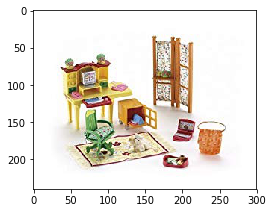

In [39]:
#Display information for selected item
for i in range(0,len(userItems)):
    print('Title and description based features')
    print(productTitleDescFeatures[productTitleDescFeatures['asin'] == userItems[i]])
    print('Review based features')
    print(dfTextF[dfTextF['asin'] == userItems[i]])

images = dfMeta[dfMeta['asin'].isin(userItems)]['imUrl'].to_list()
showImages(images)
dfMeta[dfMeta['asin'].isin(userItems)]

,asin,description,title,price,salesRank,imUrl,brand,categories,related,subCateg
3662,B00000J0NT,"Burnt sienna, olive green, thistle--the nostal...",Crayola 120ct Original Crayons,11.98,{'Toys & Games': 4371},http://ecx.images-amazon.com/images/I/51KjTfbs...,Crayola,"[[Toys & Games, Arts & Crafts, Drawing & Paint...","{'also_bought': ['B00000J0S3', 'B0019665DK', '...",Arts & Crafts
12945,B0001VVB9C,Plan Toy Doll House Doll Family with moveable ...,Plan Toy Doll Family - Caucasian,18.00,{'Toys & Games': 9410},http://ecx.images-amazon.com/images/I/41G14VpV...,Plan Toys,"[[Toys & Games, Dolls & Accessories, Dolls]]","{'also_bought': ['B0001VUSUU', 'B0001VV8Q8', '...",Dolls & Accessories
14234,B0002A5J0Y,Honey-Pie's giving My Little Ponies a run for ...,Strawberry Shortcake: Filly Groomin' Salon Wit...,68.99,{'Toys & Games': 561321},http://ecx.images-amazon.com/images/I/414TMTH1...,Bandai,"[[Toys & Games, Action Figures & Statues, Play...","{'also_viewed': ['B0001WWL0O', 'B004P958CM', '...",Action Figures & Statues
25029,B0007XIZ1Q,Come out from the shadows and into the moonlig...,Bratz Midnight Dance - Meygan,NaN,{'Toys & Games': 490095},http://ecx.images-amazon.com/images/I/513MXFX9...,NaN,"[[Toys & Games, Dolls & Accessories, Dolls]]","{'also_viewed': ['B0007XIZ1G', 'B000B65314', '...",Dolls & Accessories
63773,B000Q41VLM,".caption { font-family: Verdana, Helvetica neu...",Rose Art Smart! Easel,49.95,{'Toys & Games': 166803},http://ecx.images-amazon.com/images/I/519td1Xr...,NaN,"[[Toys & Games, Arts & Crafts, Easels]]","{'also_viewed': ['B0002AUWKG', 'B0037U1P1I', '...",Arts & Crafts
76716,B000XU4LPC,Now you can have fun - even when you're on the...,My Little Pony Ponyville Carry Case,NaN,{'Toys & Games': 209069},http://ecx.images-amazon.com/images/I/41jYklGk...,NaN,"[[Toys & Games, Dolls & Accessories, Dolls]]","{'also_bought': ['0060744472', 'B00604WA8A', '...",Dolls & Accessories
78955,B000ZPF8RA,"Busy parents love to relax in a cozy, attracti...",Fisher-Price Loving Family Parent's Room,49.99,{'Toys & Games': 74474},http://ecx.images-amazon.com/images/I/41%2BFlx...,Fisher-Price,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_bought': ['B0033V2LQE', 'B005XUI4QY', '...",Dolls & Accessories
86431,B0015EPR2Q,BARBIE Party Cruise and play on this luxurious...,BARBIE Party Cruise,169.99,{'Toys & Games': 153050},http://ecx.images-amazon.com/images/I/415ErbMH...,Mattel,"[[Toys & Games, Dolls & Accessories, Dolls]]","{'also_bought': ['B006O6EG2W', 'B004SN4OY8', '...",Dolls & Accessories
98457,B001D1FP46,The Playground set is composed of three units ...,Plan Toys Playground,17.99,{'Toys & Games': 18845},http://ecx.images-amazon.com/images/I/4185O3mj...,Plan Toys,"[[Toys & Games, Dolls & Accessories, Dollhouses]]","{'also_bought': ['B0001VVBBA', 'B000A42YM8', '...",Dolls & Accessories
171147,B003YA33Q6,A set of 36 blocks with bright colors and rais...,"Bag O' A-B-C Blocks, Natural Color",14.89,{'Toys & Games': 9317},http://ecx.images-amazon.com/images/I/415%2BR1...,Ryans Room,"[[Toys & Games, Building Toys, Stacking Blocks]]","{'also_bought': ['B004SGUQDI', 'B003Y9ZUHM', '...",Building Toys


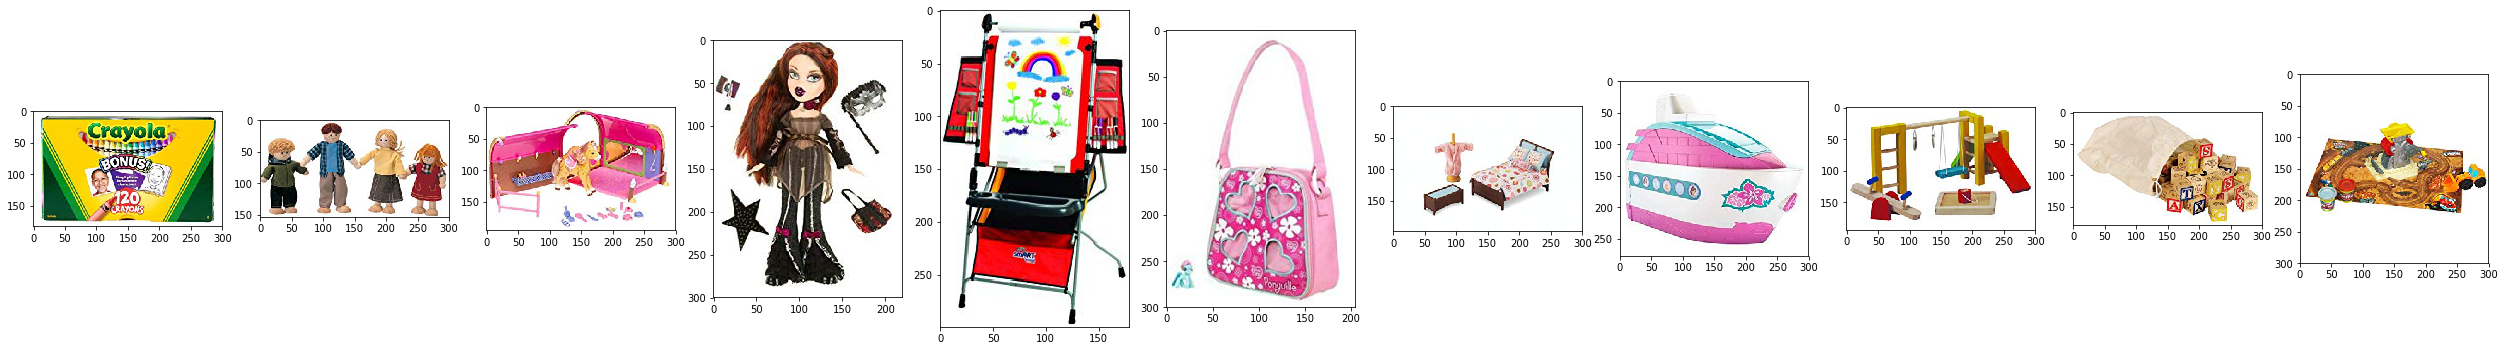

In [40]:
#Call the function for finding similar items using text and title features, and display results
simItemsList = findSimilarsText(userItems)
images = dfMeta[dfMeta['asin'].isin(simItemsList)]['imUrl'].to_list()
showImages(images)
dfMeta[dfMeta['asin'].isin(simItemsList)]
# print(simItemsList)

,asin,description,title,price,salesRank,imUrl,brand,categories,related,subCateg
54164,B000LT2IGE,A comfortable living room is just the place fo...,Fisher-Price Loving Family Loving Family Livin...,11.48,{'Toys & Games': 79346},http://ecx.images-amazon.com/images/I/414aKsnx...,Fisher-Price,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_bought': ['B001JQLJJA', 'B001JK4MRM', '...",Dolls & Accessories
78955,B000ZPF8RA,"Busy parents love to relax in a cozy, attracti...",Fisher-Price Loving Family Parent's Room,49.99,{'Toys & Games': 74474},http://ecx.images-amazon.com/images/I/41%2BFlx...,Fisher-Price,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_bought': ['B0033V2LQE', 'B005XUI4QY', '...",Dolls & Accessories
86808,B0015KSSTY,Little girls love to play pretend&mdash;especi...,Fisher-Price Loving Family Grand Dollhouse,79.49,{'Toys & Games': 30100},http://ecx.images-amazon.com/images/I/51rrrRIC...,Fisher-Price,"[[Toys & Games, Dolls & Accessories, Dollhouses]]","{'also_bought': ['B001JQLJJA', 'B001JK4MRM', '...",Dolls & Accessories
106734,B001JQLJJA,New Premium Kitchen in contemporary styling th...,Fisher-Price Loving Family Dollhouse Kitchen,18.99,{'Toys & Games': 3606},http://ecx.images-amazon.com/images/I/41rpCvzI...,Fisher-Price,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_bought': ['B0033V2LQE', 'B001JK4MRM', '...",Dolls & Accessories


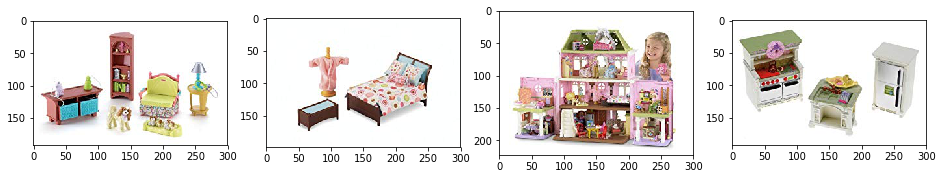

In [41]:
userItemsMF = userItems
simItemsListMF = findSimilarsMF(userItemsMF)
images = dfMeta[dfMeta['asin'].isin(simItemsListMF)]['imUrl'].to_list()
showImages(images)
dfMeta[dfMeta['asin'].isin(simItemsListMF)]

['B0044KN82O', 'B0044KN86A', 'B009SH8PQ2', 'B005XUI4QY', 'B0033V2LQE', 'B005XUI5AE', 'B003GRJ3RK', 'B006PGLVCY', 'B006EPCLPC', 'B001JQLJJA', 'B009SH8PWG', 'B00309LG24', 'B006EOWPY0', 'B001356Q0O', 'B001JK4MRM', 'B000LT2IGE', 'B005XUI5QI', 'B0074NVH8A', 'B0074NVGKO', 'B009SH8PS0', 'B0044KN85Q', 'B006EP74CC', 'B0068M4PE6', 'B00B5QFJ40', 'B000LT1CJS', 'B009HCE5Q2', 'B009SH8POE', 'B0074NVGKE', 'B00DCRVD6I', 'B004UU9XG8', 'B001M5MQ7C', 'B008C5FQOK', 'B005HPI8N4', 'B00080M50A', 'B00080M500', 'B006EPFHGW', 'B006EPE3W6', 'B001TGTMLW', 'B001TOMS9C', 'B0015KSSTY', 'B0077NCEX4', 'B000OL9SM6', 'B0037USWC8', 'B002SNIK4U', 'B00E1EW6XU', 'B00409FTDK', 'B005PIHMZ8', 'B000JVDVQA', 'B001TGV4O0', 'B004FOOUTO', 'B000FEBVF4', 'B000FEBVFE', 'B004YCZOF6', 'B000NQA4EI', 'B000YBH0NK', 'B000ZPF8RA', 'B00B3ZZ8L2', 'B0041LM6QU', 'B00085EWXS', 'B000JVBQQM']


,asin,description,title,price,salesRank,imUrl,brand,categories,related,subCateg
25535,B00080M500,Mama dog and her puppy are always ready to pla...,Loving Family Puppy Playtime,19.68,{'Toys & Games': 33624},http://ecx.images-amazon.com/images/I/417A5FD9...,Fisher-Price,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_bought': ['B001356Q0O', 'B006EPCLPC', '...",Dolls & Accessories
25538,B00080M50A,Decorating the outside of a dollhouse is just ...,Loving Family Garden Fun,20.88,{'Toys & Games': 150183},http://ecx.images-amazon.com/images/I/51GCHA91...,Fisher-Price,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_bought': ['B0044KN82O', 'B0044KN86A', '...",Dolls & Accessories
25828,B00085EWXS,Welcome the family for dinner celebrations or ...,Fisher Price Loving Family Dining Room,81.99,{'Toys & Games': 279924},http://ecx.images-amazon.com/images/I/411N7ZFD...,NaN,"[[Toys & Games, Dolls & Accessories, Playsets]]","{'also_bought': ['B003GRJ3RK', 'B0044KN86A', '...",Dolls & Accessories
40686,B000FEBVF4,Families come in different shapes and sizes an...,Loving Family Dollhouse Figures: Mom &amp; Tod...,18.99,{'Toys & Games': 44510},http://ecx.images-amazon.com/images/I/4123dvej...,Loving Family,"[[Toys & Games, Dolls & Accessories, Dolls]]","{'also_bought': ['B000FEBVFE', 'B006EPFHGW', '...",Dolls & Accessories
40687,B000FEBVFE,Fisher Price Loving Family Dad & Sister \nYear...,Fisher Price Loving Family Dollhouse Figures: ...,23.98,{'Toys & Games': 90822},http://ecx.images-amazon.com/images/I/41CBq6rZ...,Loving Family,"[[Toys & Games, Dolls & Accessories, Dolls]]","{'also_bought': ['B000FEBVF4', 'B006EPE3W6', '...",Dolls & Accessories
51282,B000JVBQQM,"Its a bedroom fit for a princess, with room fo...",Fisher-Price Loving Family Kids Bedroom,NaN,{'Toys & Games': 245101},http://ecx.images-amazon.com/images/I/513QkGvr...,NaN,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_bought': ['B009SH8PQ2', 'B006EPCLPC', '...",Dolls & Accessories
51284,B000JVDVQA,NaN,Fisher-Price Loving Family Grandma and Brother...,39.99,{'Toys & Games': 160799},http://ecx.images-amazon.com/images/I/41VtzqdJ...,Loving Family,"[[Toys & Games, Dolls & Accessories, Dolls]]","{'also_bought': ['B006EPCLPC', 'B0068M4PE6', '...",Dolls & Accessories
54134,B000LT1CJS,A beautifully equipped laundry room makes clea...,Fisher Price Loving Family Laundry Room,34.95,{'Toys & Games': 149969},http://ecx.images-amazon.com/images/I/41civLuw...,Fisher-Price,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_bought': ['B0033V2LQE', 'B005XUI5AE', '...",Dolls & Accessories
54164,B000LT2IGE,A comfortable living room is just the place fo...,Fisher-Price Loving Family Loving Family Livin...,11.48,{'Toys & Games': 79346},http://ecx.images-amazon.com/images/I/414aKsnx...,Fisher-Price,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_bought': ['B001JQLJJA', 'B001JK4MRM', '...",Dolls & Accessories
58810,B000NQA4EI,Your little girl will love playing with Sugar ...,Fisher Price Loving Family Sugar English Horse,29.40,{'Toys & Games': 131665},http://ecx.images-amazon.com/images/I/412seIgb...,Fisher-Price,"[[Toys & Games, Dolls & Accessories, Dolls]]","{'also_bought': ['B000OL9SM6', 'B009HCE5Q2', '...",Dolls & Accessories


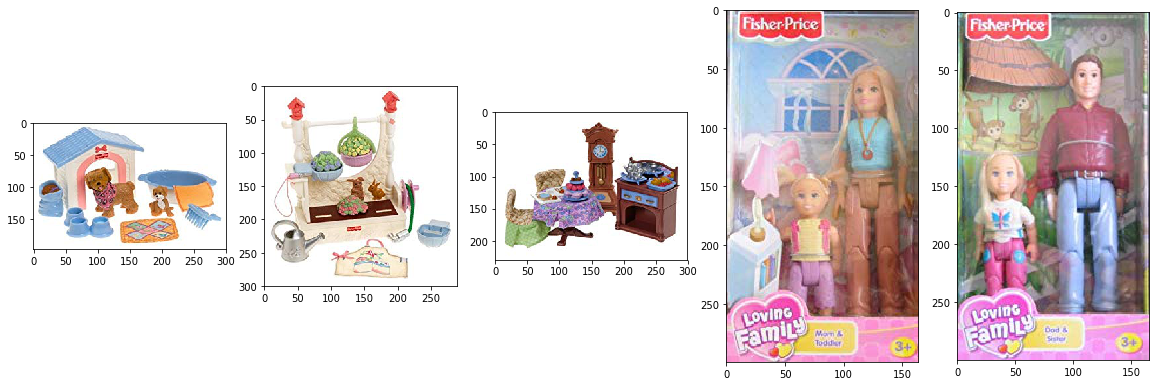

In [42]:
### Also bought from metadata
d = dfMeta[dfMeta['asin'].isin(userItems)]['related'].reset_index(drop = True)
alsoBoughtItems = d[0]['also_bought']
print(alsoBoughtItems)
images = dfMeta[dfMeta['asin'].isin(d[0]['also_bought'])]['imUrl'].to_list()
showImages(images[:5])
dfMeta[dfMeta['asin'].isin(d[0]['also_bought'])]

['B001JQLJJA', 'B005XUI4QY', 'B0044KN86A', 'B003GRJ3RK', 'B009SH8PQ2', 'B000LT2IGE', 'B0033V2LQE', 'B0044KN82O', 'B005XUI5AE', 'B009SH8POE', 'B00080M50A', 'B0074NVGKO', 'B00B5QFJ40', 'B005HPI8N4', 'B0074NVH8A', 'B005XUI5QI', 'B001JK4MRM', 'B00409FTDK', 'B00309LG24', 'B004UU9XG8', 'B009HCE5Q2', 'B000LT1CJS', 'B001356Q0O', 'B005PIHMZ8', 'B0044KN85Q', 'B009G4K3F8', 'B0074NVGKE', 'B00B3ZZ8L2', 'B00DCRVD6I', 'B00080AQEM', 'B009SH8PS0', 'B0015KSSTY', 'B009SH8PWG', 'B00080M500', 'B00E6EG6TU', 'B001TOMS9C', 'B00E1EW6XU', 'B0077NCEX4', 'B001M5MQ7C', 'B00E6EC9XW', 'B0037USWC8', 'B004FOOUTO', 'B002SNIK4U', 'B00029UDLA', 'B001TGV4O0', 'B006PGLVCY', 'B006EP74CC', 'B001TGTMLW', 'B000HYOVPO', 'B009O4MTCU', 'B008C5FQOK', 'B0012S64J0', 'B000ZPF8RA', 'B006EPCLPC', 'B0007UB5YI', 'B009O3O708', 'B000JVBQQM', 'B0007WX0EO']


,asin,description,title,price,salesRank,imUrl,brand,categories,related,subCateg
14215,B00029UDLA,Loving Family Dollhouse Pool Party Playset Fea...,Loving Family Pool Party,149.95,{'Toys & Games': 854811},http://ecx.images-amazon.com/images/I/41M5EPJZ...,NaN,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_viewed': ['B004UU9XG8', 'B005XUI4QY', '...",Dolls & Accessories
24386,B0007UB5YI,".caption { font-family: Verdana, Helvetica neu...",Fisher-Price Loving Family Twin Time Dollhouse,349.99,{'Toys & Games': 412129},http://ecx.images-amazon.com/images/I/510bBeLL...,NaN,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_viewed': ['B005XUI4QY', 'B001356Q0O', '...",Dolls & Accessories
24816,B0007WX0EO,The new family SUV compliments the realistic p...,Loving Family SUV,133.33,{'Toys & Games': 328553},http://ecx.images-amazon.com/images/I/4173K2H5...,NaN,"[[Toys & Games, Toy Remote Control & Play Vehi...","{'also_viewed': ['B001356Q0O', 'B008C5FQOK', '...",Toy Remote Control & Play Vehicles
25447,B00080AQEM,"Taking care of baby twins is a lot of fun, esp...",Fisher Price Loving Family Nursery,NaN,{'Toys & Games': 376219},http://ecx.images-amazon.com/images/I/410NVA9C...,NaN,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_viewed': ['B005XUI4QY', 'B005XUI5AE', '...",Dolls & Accessories
25535,B00080M500,Mama dog and her puppy are always ready to pla...,Loving Family Puppy Playtime,19.68,{'Toys & Games': 33624},http://ecx.images-amazon.com/images/I/417A5FD9...,Fisher-Price,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_bought': ['B001356Q0O', 'B006EPCLPC', '...",Dolls & Accessories
25538,B00080M50A,Decorating the outside of a dollhouse is just ...,Loving Family Garden Fun,20.88,{'Toys & Games': 150183},http://ecx.images-amazon.com/images/I/51GCHA91...,Fisher-Price,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_bought': ['B0044KN82O', 'B0044KN86A', '...",Dolls & Accessories
47515,B000HYOVPO,"Make any time family time with a comfy sofa, c...",Fisher Price Loving Family Dollhouse Family Room,NaN,{'Toys & Games': 244823},http://ecx.images-amazon.com/images/I/31ywND2z...,NaN,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_bought': ['B009SH8PQ2', 'B001JQLJJA', '...",Dolls & Accessories
51282,B000JVBQQM,"Its a bedroom fit for a princess, with room fo...",Fisher-Price Loving Family Kids Bedroom,NaN,{'Toys & Games': 245101},http://ecx.images-amazon.com/images/I/513QkGvr...,NaN,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_bought': ['B009SH8PQ2', 'B006EPCLPC', '...",Dolls & Accessories
54134,B000LT1CJS,A beautifully equipped laundry room makes clea...,Fisher Price Loving Family Laundry Room,34.95,{'Toys & Games': 149969},http://ecx.images-amazon.com/images/I/41civLuw...,Fisher-Price,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_bought': ['B0033V2LQE', 'B005XUI5AE', '...",Dolls & Accessories
54164,B000LT2IGE,A comfortable living room is just the place fo...,Fisher-Price Loving Family Loving Family Livin...,11.48,{'Toys & Games': 79346},http://ecx.images-amazon.com/images/I/414aKsnx...,Fisher-Price,"[[Toys & Games, Dolls & Accessories, Dollhouse...","{'also_bought': ['B001JQLJJA', 'B001JK4MRM', '...",Dolls & Accessories


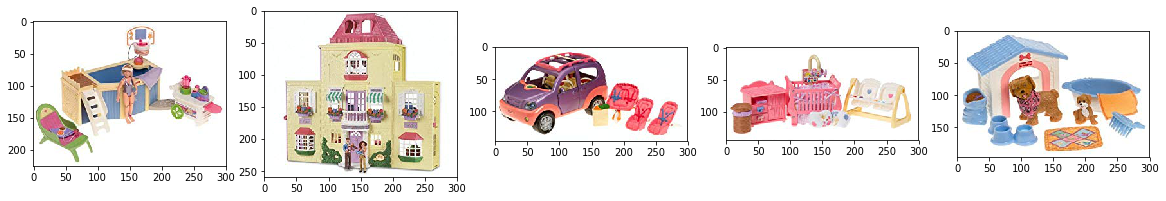

In [43]:
### Also viewed from metadata
d = dfMeta[dfMeta['asin'].isin(userItems)]['related'].reset_index(drop = True)
alsoViewedItems = d[0]['also_viewed']
print(alsoViewedItems)
images = dfMeta[dfMeta['asin'].isin(d[0]['also_viewed'])]['imUrl'].to_list()
showImages(images[:5])
dfMeta[dfMeta['asin'].isin(d[0]['also_viewed'])]

common items for text and also bought count: 1 asin ['B000ZPF8RA']
common items for text and also viewed 1 ['B000ZPF8RA']
common items for MF and also bought 6 ['B000LT2IGE', 'B000ZPF8RA', 'B0015KSSTY', 'B001JQLJJA', 'B000LT2IGE', 'B000ZPF8RA']
common items for MF and also viewed 6 ['B000LT2IGE', 'B000ZPF8RA', 'B0015KSSTY', 'B001JQLJJA', 'B000LT2IGE', 'B000ZPF8RA']
length of also bought, also viewed and their intersection 60 58 47
length of intersection of text recommendations and MF recommendations 12 6 1


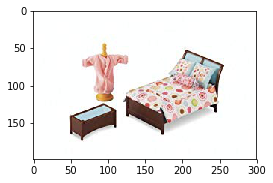

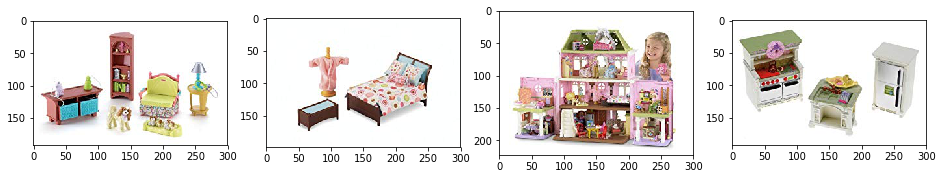

In [44]:
#Checking if recommend items are in also bought, or also viewed
commonItemsText = []
commonItemsMF = []


commonItemsTextAB = [i for i in simItemsList if i in alsoBoughtItems]
print('common items for text and also bought count:',len(commonItemsTextAB),'asin',commonItemsTextAB)
commonItemsText.extend(commonItemsTextAB)
commonItemsTextAV = [i for i in simItemsList if i in alsoViewedItems]
print('common items for text and also viewed',len(commonItemsTextAV),commonItemsTextAV)
commonItemsText.extend(commonItemsTextAV)

commonItemsMFAB = [i for i in simItemsListMF if i in alsoBoughtItems]
print('common items for MF and also bought',len(commonItemsMFAB),commonItemsMFAB)
commonItemsMF.extend(commonItemsMFAB)
commonItemsMFAV = [i for i in simItemsListMF if i in alsoViewedItems]
print('common items for MF and also viewed',len(commonItemsMFAV),commonItemsMFAV)
commonItemsMF.extend(commonItemsMFAV)

commonItemsABAV = [i for i in alsoBoughtItems if i in alsoViewedItems]
print('length of also bought, also viewed and their intersection',len(alsoBoughtItems),len(alsoViewedItems),len(commonItemsABAV))

commonItemsTextMF = [i for i in simItemsList if i in simItemsListMF]
print('length of intersection of text recommendations and MF recommendations',len(simItemsList),len(simItemsListMF),len(commonItemsTextMF))

images = dfMeta[dfMeta['asin'].isin(commonItemsText)]['imUrl'].to_list()
showImages(images)
trial = dfMeta[dfMeta['asin'].isin(commonItemsText)]
images = dfMeta[dfMeta['asin'].isin(commonItemsMF)]['imUrl'].to_list()
showImages(images)

In [18]:
def parse(path):
  print('start parse')
  start_parse = time.time()
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
  end_parse = time.time()
  print('end parse with time for parse',end_parse - start_parse)

def getDF(path):
  print('start getDF')
  start = time.time()
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  print('end getDF')
  end = time.time()
  print('time taken to load data = ',end-start)
  return pd.DataFrame.from_dict(df, orient='index')
dfReviews = getDF('reviews_Toys_and_Games_5.json.gz')

start getDF
start parse
end parse with time for parse 8.05751657485962
end getDF
time taken to load data =  8.05751657485962


In [19]:
users = dfReviews.groupby('reviewerID').agg('count')
users.head()

,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
reviewerID,,,,,,,,
A012468118FTQAINEI0OQ,6,6,6,6,6,6,6,6
A0182108CPDLPRCXQUZQ,8,8,8,8,8,8,8,8
A026961431MGW0616BRS3,6,6,6,6,6,6,6,6
A034597326Z83X79S50FI,7,7,7,7,7,7,7,7
A04295422T2ZG087R17FX,5,5,5,5,5,5,5,5


In [20]:
userProds = pd.DataFrame(index = users.index, columns = ['reviewedProds'])
for ix in userProds.index:
    userProds.loc[ix,'reviewedProds'] = dfReviews[dfReviews['reviewerID'] == ix]['asin'].to_list()

In [21]:
userProds.head()

,reviewedProds
reviewerID,
A012468118FTQAINEI0OQ,"[B00005BZM6, B001HA9JOA, B002BY2BVE, B003S7EYZ..."
A0182108CPDLPRCXQUZQ,"[B002IUNLLK, B007WYU7R8, B008B68IUY, B00ABY8WV..."
A026961431MGW0616BRS3,"[B000ID1E0O, B001GGRBU4, B002I4OTA8, B0042TBGC..."
A034597326Z83X79S50FI,"[B00000J0S3, B000PTZMKO, B002CICG3M, B002RL7VN..."
A04295422T2ZG087R17FX,"[B003TLATUS, B003V1MN3C, B0085HJQRI, B0085HLG9..."


In [22]:
userProds.shape

(19412, 1)

In [388]:
userProds.to_csv('ProductsReviewedByUser5.csv')

In [124]:
textSimItemsList = []
for prod in prodList:
    userItems = [prod]
    simItemsList = findSimilarsText(userItems)
    for item in simItemsList:
        for userItem in userItems:
            if item != userItem:
                textSimItemsList.append(item)

print(len(textSimItemsList))

141687


In [125]:
a  = Counter(textSimItemsList)
print('coverage of text features =',len(a)/len(prodList))
a.most_common(20)

coverage of text features = 0.7067332092708509


[('B00000DMFN', 840),
 ('0786950072', 834),
 ('B00000DMF6', 809),
 ('B00000DMF5', 800),
 ('B00000ISUK', 774),
 ('B00000DMBB', 761),
 ('B000046S2Q', 728),
 ('B00000J1DM', 716),
 ('B00003GPTI', 641),
 ('B00000IW3I', 638),
 ('0735308365', 637),
 ('B00005BMX9', 626),
 ('0786958731', 604),
 ('B00000IW3G', 602),
 ('B00005BHK6', 589),
 ('0976142503', 576),
 ('B00004TBFB', 564),
 ('0975277383', 563),
 ('B00000DMCE', 552),
 ('B00000DMC6', 548)]

In [ ]:
#len(textSimItemsList) : 

#text features
# 4 in category, 2 any category : 70863
# 6 in category, 6 any category : 141687

#Mf features:
# 4 in category, 2 any category : 55388
# 6 in category, 6 any category : 114651

In [158]:
MFSimItemsList = []
for prod in prodList:
    userItems = [prod]
    simItemsList = findSimilarsMF(userItems)
    for item in simItemsList:
        for userItem in userItems:
            if item != userItem:
                MFSimItemsList.append(item)

print(len(MFSimItemsList))

114651


In [159]:
b  = Counter(MFSimItemsList)
print('coverage of MF features =',len(b)/len(prodList))
b.most_common(20)

coverage of MF features = 0.9957705971916765


[('1616611898', 108),
 ('B0033PSLUK', 96),
 ('B002I44FDE', 91),
 ('B00005BY3W', 87),
 ('B001TK3LUG', 81),
 ('1589946464', 80),
 ('B001RLZ3PI', 76),
 ('1938146905', 75),
 ('B002V8UYRI', 73),
 ('1616611359', 72),
 ('1938146999', 72),
 ('B004KUCMXY', 70),
 ('B003UC0OKG', 69),
 ('B0037UUZAK', 69),
 ('B0000DJ3E1', 66),
 ('B004XPIQJ0', 66),
 ('B000UW1ODA', 64),
 ('1616615044', 63),
 ('9269809579', 63),
 ('B001TK3LSI', 62)]

In [120]:
## Relevance using also bought as a baseline. Measure overlap with also bought.

prodsWithProdsinAlsoBought = []
textSimItemsOverlapAlsoBought = []
MFSimItemsOverlapAlsoBought = []
testMFSimOverlap = []
commonItemsTextABCount = 0
commonItemsMFABCount = 0
commonItemsMFTextCount = 0
itemsWithNoAlsoBought = []
i = 0
for prod in prodList:
#     print(prod)
    userItems = [prod] #['B00000DMBF']
    simItemsList = findSimilarsText(userItems)
#     print(simItemsList)
    simItemsListMF = findSimilarsMF(userItems)
#     print(simItemsListMF)
    d = dfMeta[dfMeta['asin'].isin(userItems)]['related'].reset_index(drop = True)
    if d.any():
#         print(d[0])
        alsoBoughtItems = []
        if 'also_bought' in d[0]:
            alsoBoughtItems.extend(d[0]['also_bought'])
        if 'bought_together' in d[0]:
#             print('yes')
            alsoBoughtItems.extend(d[0]['bought_together'])
#         print('also_bought',alsoBoughtItems)
        if len(alsoBoughtItems) > 0:
            commonItemsTextAB = [i for i in simItemsList if i in alsoBoughtItems]
            commonItemsMFAB = [i for i in simItemsListMF if i in alsoBoughtItems]
            commonItemsMFText = [i for i in simItemsListMF if i in simItemsList]
#             print('Text Also bought',commonItemsTextAB)
#             print('MF Also Bought',commonItemsMFAB)
#             print('MF text overlap',commonItemsMFText)
            textSimItemsOverlapAlsoBought.extend(commonItemsTextAB)
            MFSimItemsOverlapAlsoBought.extend(commonItemsMFAB)
            testMFSimOverlap.extend(commonItemsMFText)
            commonItemsTextABCount += len(commonItemsTextAB)
            commonItemsMFABCount += len(commonItemsMFAB)
            commonItemsMFTextCount += len(commonItemsMFText)
            if len(alsoBoughtItems) > 0:
                prodsWithProdsinAlsoBought.append(prod)
        else:
            itemsWithNoAlsoBought.append(prod)
#             print(prod,'no also bought items')
    i+= 1
    if i%100 == 0:
        print(i)

print(commonItemsTextABCount, commonItemsMFABCount, commonItemsMFTextCount)

# print(len(textSimItemsList))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
10760 29258 3398


In [122]:
print(commonItemsTextABCount, commonItemsMFABCount, commonItemsMFTextCount)
print(len(prodsWithProdsinAlsoBought),len(textSimItemsOverlapAlsoBought),len(itemsWithNoAlsoBought))
# itemsWithNoAlsoBought

10760 29258 3398
11167 10760 524


### Correlation with popularity / novelty of recommendations:

In [162]:
dfReviews.head()
numRatingsByProduct = dfReviews.groupby('asin').agg('count').reset_index()
numRatingsByProduct.head()

dfTextSimCounter = pd.DataFrame.from_dict(a, orient='index').reset_index()
dfTextSimCounter.rename(columns = {'index':'asin',0:'NRecommend'}, inplace = True)
dfTextSimCounter.head()

dfMFSimCounter = pd.DataFrame.from_dict(b, orient='index').reset_index()
dfMFSimCounter.rename(columns = {'index':'asin',0:'NRecommendMF'}, inplace = True)
dfMFSimCounter.head()

,asin,NRecommendMF
0,B003NVJ9KA,7
1,B00ARV3CKM,5
2,B0015KEB2M,11
3,B001L0QXZY,4
4,B004HAW1EM,6


In [164]:
textCorrDf = pd.merge(numRatingsByProduct[['asin','reviewText']],dfTextSimCounter,left_on = ['asin'],right_on = ['asin'], how = 'left')
textCorrDf = pd.merge(textCorrDf,dfMFSimCounter,left_on = ['asin'],right_on = ['asin'], how = 'left')
textCorrDf.head()
textCorrDf.corr()

,reviewText,NRecommend,NRecommendMF
reviewText,1.000000,0.077964,0.115003
NRecommend,0.077964,1.000000,0.025887
NRecommendMF,0.115003,0.025887,1.000000


### Items where feature extraction is working well

B0039QM1MC
B000QH12OK
B000FEBVEK



### Items where feature extraction is not working well

B004PBEV96

### Items where extracted products are OK, but can be improved.
B007LL7N4C (dinosaur - also bought are all along the dinosaur theme. our recommendations are not so much)

